## 1. Standard Imports

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt

## 2. Create temporal Sequences

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
# number of Datapoints
N = 500
# range : [0, 30pi]
t_arr = np.linspace(start=0 ,stop=30*np.pi ,num=N)

data = torch.zeros(N)

for idx, t in enumerate(t_arr):
    
    x = np.sin(t + np.cos(t))
    #x = np.sin(t)
    x = np.round(x, 4)
    #data.append( x )
    data[idx] = torch.tensor(x)

#### Data visualization

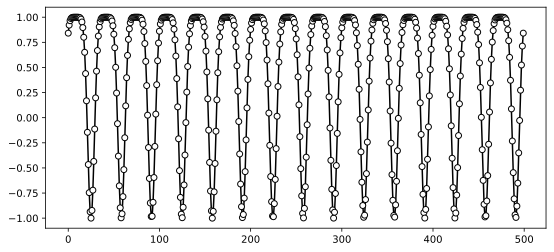

In [5]:
plt.figure(figsize=(9,4), dpi=135)

#plt.plot([-2,N+1],[0,0],'--', color=[.8,.8,.8])
plt.plot(data,'ko-',markerfacecolor='w')
#plt.xlim([-1,N+1])

plt.show()

## 3. Create a Custom RNN class

In [6]:
class rnnnet(nn.Module):
    
    def __init__(self,InputSize, HiddenSize, NumLayers=1):
        
        super().__init__()

        # RNN Layer
        self.rnn = nn.RNN(InputSize,HiddenSize,NumLayers)

        # linear layer for output
        self.out = nn.Linear(HiddenSize,1)
  
    def forward(self, x):

        # run through the RNN layer
        y,hidden_state = self.rnn(x) # no explicit hidden state initialization

        # and the output (linear) layer
        y = self.out(y)

        return y, hidden_state

## 4. Create instance and Testing of the RNN Model

In [7]:
# network parameters
input_size =  1  # "channels" of data
hidden_size = 5  # breadth of model (number of units in hidden layers)
num_layers =  1  # depth of model (number of "stacks" of hidden layers)

# Input data parameters
batchsize  =  1  # Note: the training code is actually hard-coded to organize data into batchsize=1
seqlength  =  9  # number of datapoints used for learning in each segment

# create an instance of the model and inspect
net = rnnnet(InputSize=input_size,
             HiddenSize=hidden_size,
             NumLayers=num_layers)

In [8]:
X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X)

In [9]:
print("Input Shape : ",X.shape)

# Note: one output per sequence element; 
# generally, we take the final output to force a "many-to-one" design.
print("RNN Output Shape :",y.shape) 

print("Hidden state Shape:",h.shape)

Input Shape :  torch.Size([9, 1, 1])
RNN Output Shape : torch.Size([9, 1, 1])
Hidden state Shape: torch.Size([1, 1, 5])


#### Testing with data

In [10]:
data.shape
# first order tensor

torch.Size([500])

In [11]:
# Coverting 1D tensor into 3D tensor
somedata = data[:seqlength].view(seqlength,1,1)
y = net(somedata)

# grab the final predicted value from the output 
# (first element of tuple output of net)
print(y[0].shape)
finalValue = y[0][-1]

torch.Size([9, 1, 1])


In [12]:
print(finalValue)

tensor([[0.3542]], grad_fn=<SelectBackward0>)


In [13]:
lossfun = nn.MSELoss()
# Will take 9 sequences to predict the 10th sequence
lossfun(finalValue, data[seqlength].view(1,1))

tensor(0.4171, grad_fn=<MseLossBackward0>)

## 5. Train the model

In [14]:
# Number of training epochs
numepochs = 30
input_size = 1
hidden_size = 5
num_layers = 1
batchsize = 1

# other parameters
N = len(data)
seqlength = int(( ( 2*np.pi - 0 )*(N-1)/(30*np.pi -1) ) + 1 )

# create a new instance of the model (and optimizer!)
net = rnnnet(input_size,hidden_size,num_layers)
optimizer = torch.optim.SGD(net.parameters(),lr=.001)
lossfun = nn.MSELoss()


# initialize losses
losses = np.zeros(numepochs)


# loop over epochs
for epochi in range(numepochs):

    # loop over data segments
    seglosses = []
    #segacc    = []
    # reset the hidden state on each epoch
    hidden_state = torch.zeros(num_layers, batchsize, hidden_size) 

    for timei in range(N-seqlength):

        # grab a snippet of data
        X = data[timei:timei+seqlength].view(seqlength, 1, 1)
        # Will take 9 sequences to predict the 10th sequence
        y_actual = data[timei+seqlength].view(1,1)

        # forward pass and loss
        yHat,hidden_state = net(X)
        finalValue = yHat[-1]
        loss = lossfun(finalValue,y_actual) # compare final value of output

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this segment
        seglosses.append(loss.item())

  
    # average losses from this epoch
    losses[epochi] = np.mean(seglosses)
    

    msg = f'Finished epoch {epochi+1}/{numepochs}'
    sys.stdout.write('\r' + msg)

Finished epoch 30/30

In [15]:
losses

array([0.47502221, 0.14345709, 0.08610928, 0.06005446, 0.04309717,
       0.03035333, 0.02149487, 0.01611181, 0.0130908 , 0.01139902,
       0.0103789 , 0.00968562, 0.00915693, 0.00871971, 0.00834038,
       0.00800233, 0.00769624, 0.00741621, 0.00715804, 0.00691855,
       0.00669524, 0.00648609, 0.00628944, 0.00610393, 0.00592839,
       0.00576185, 0.00560349, 0.0054526 , 0.00530857, 0.00517087])

## Results Visualization

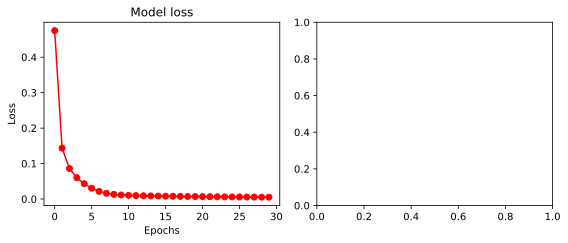

In [16]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5), dpi=135)

ax[0].plot(losses,'ro-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

# ax[1].plot(signaccuracy,'bo-',markerfacecolor='g',)
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Accuracy')
# ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.tight_layout()
plt.show()

## 6. Test the trained model 

### (i) Data generated from same function as trained data

In [17]:
# number of Datapoints
N_test = 200
# range : [0, 10pi]
t_arr = np.linspace(start=0 ,stop=10*np.pi ,num=N_test)

data_test = torch.zeros(N_test)

for idx, t in enumerate(t_arr):
    
    x = np.sin(t + np.cos(t))
    #x = np.sin(t)
    x = np.round(x, 4)
    #data.append( x )
    data_test[idx] = torch.tensor(x)

In [18]:
yHat = np.zeros(N_test)

for timei in range(N_test-seqlength):

    # grab a snippet of data
    X = data_test[timei:timei+seqlength].view(seqlength,1,1)

    # forward pass and loss
    ypred,hh = net(X)
    
    yHat[timei+seqlength] = ypred[-1]
    

### Results Visualization

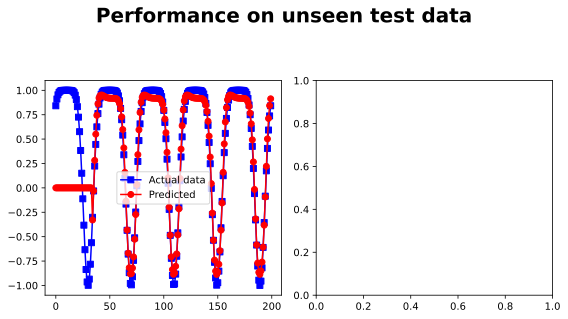

In [19]:
fig,ax = plt.subplots(1,2,figsize=(8,4), dpi=135)

ax[0].plot(data_test,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
#ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

# ax[1].plot(newdata-yHat,'k^')
# ax[1].set_ylim([-1.1,1.1])
# ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20, y=1.1)
plt.tight_layout()

plt.show()

### (ii) Data generated from different function

In [20]:
# number of Datapoints
N_test = 200
# range : [0, 10pi]
t_arr = np.linspace(start=0 ,stop=10*np.pi ,num=N_test)

data_test2 = torch.zeros(N_test)

for idx, t in enumerate(t_arr):
    
    x = np.sin(t + np.sin(t))
    #x = np.sin(t)
    x = np.round(x, 4)
    #data.append( x )
    data_test2[idx] = torch.tensor(x)

In [21]:
yHat2 = np.zeros(N_test)

for timei in range(N_test-seqlength):

    # grab a snippet of data
    X = data_test2[timei:timei+seqlength].view(seqlength,1,1)

    # forward pass 
    ypred,hh = net(X)
    
    yHat2[timei+seqlength] = ypred[-1]
    

### Results Visualization

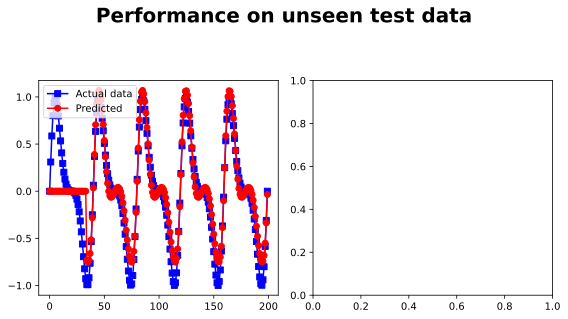

In [22]:
fig,ax = plt.subplots(1,2,figsize=(8,4), dpi=135)

ax[0].plot(data_test2,'bs-',label='Actual data')
ax[0].plot(yHat2,'ro-',label='Predicted')
#ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

# ax[1].plot(newdata-yHat,'k^')
# ax[1].set_ylim([-1.1,1.1])
# ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20, y=1.1)
plt.tight_layout()

plt.show()

## testing 

In [23]:
data[:seqlength]

tensor([ 0.8415,  0.9212,  0.9655,  0.9872,  0.9962,  0.9992,  0.9999,  1.0000,
         1.0000,  1.0000,  1.0000,  0.9998,  0.9985,  0.9939,  0.9811,  0.9525,
         0.8968,  0.8006,  0.6509,  0.4392,  0.1679, -0.1455, -0.4661, -0.7463,
        -0.9366, -0.9998, -0.9229, -0.7215, -0.4350, -0.1131,  0.1973,  0.4632,
         0.6686,  0.8125])

In [30]:
len(data)

500

In [31]:
n_iter = 700
yHat3 = np.zeros(n_iter)

data_initial = data[:seqlength]

arr = np.array([])

for timei in range(n_iter-seqlength):
    
    # grab a snippet of data
    X = data_initial[timei:timei+seqlength].view(seqlength,1,1)
    
    # forward pass 
    ypred,hh = net(X)
    
    yHat3[timei+seqlength] = ypred[-1]
    
    y_pred_np = ypred[-1].detach().numpy()
    data_initial = np.array(data_initial)
    
    data_initial = np.append(data_initial,y_pred_np )
    
    data_initial = torch.tensor(data_initial)
    
    msg = f'Finished epoch {timei+1}/{n_iter-seqlength}'
    sys.stdout.write('\r' + msg)

Finished epoch 666/666

### Results Visualization

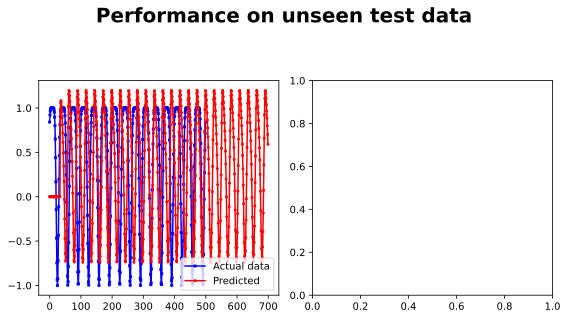

In [35]:
fig,ax = plt.subplots(1,2,figsize=(8,4), dpi=135)

ax[0].plot(data,'bs-',label='Actual data', markersize=2)
ax[0].plot(yHat3,'ro-',label='Predicted', markersize=2)
#ax[0].set_xlim([0,100])
ax[0].legend()

# ax[1].plot(newdata-yHat,'k^')
# ax[1].set_ylim([-1.1,1.1])
# ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20, y=1.1)
plt.tight_layout()

plt.show()

- Sometimes we can observe the decaying pattern in the prediction.